V tem "notebooku" bom implementiral binarni klasifikator, ki bo na podlagi naslovov dnevnih novic, napovedal gibanje borznega indeksa. 
Na začetku naložim in uvozim potrebne knjižnice.

In [1]:
#remove.packages(c("ggplot2", "data.table"))
#install.packages('Rcpp', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('ggplot2', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#install.packages('data.table', dependencies = TRUE, repos = "http://cran.us.r-project.org")
#library(tidyverse)
library(ggplot2)
library(rvest)
library(gsubfn)
library(readr)
library(dplyr)


Warning message:
"package 'ggplot2' was built under R version 3.3.3"Warning message:
"package 'rvest' was built under R version 3.3.3"Loading required package: xml2
Warning message:
"package 'xml2' was built under R version 3.3.3"Warning message:
"package 'gsubfn' was built under R version 3.3.3"Loading required package: proto
Warning message:
"package 'proto' was built under R version 3.3.3"Could not load tcltk.  Will use slower R code instead.
Warning message:
"package 'readr' was built under R version 3.3.3"
Attaching package: 'readr'

The following object is masked from 'package:rvest':

    guess_encoding

Warning message:
"package 'dplyr' was built under R version 3.3.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Obravnaval bom gibanje ameriškega borznega indeksa Dow Jones. Podatke sem zajel z naslednje strani:
https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0

Pri delu sem si pomagal s knjižnico RVEST in regularnimi izrazi. Ker so se podatki nahajali na različnih straneh, sem s for zanko poskrbel, da sem zajel podatke z vsake izmed njih (spreminjal sem samo parameter 'start' v url naslovih). Zbrana tabela obsega podatke o dnevnem gibanju za 8 let (2008-2016). Tabeli sem dodal še stolpec "Gibanje", ki pove, ali se je tisti dan indeks premaknil nazvgor (1) ali navzdol (0). Na koncu zbrane in urejene podatke shranim v datoteko "DowJones.csv".

In [7]:
link <- "https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0"
stran <- html_session(link) %>% read_html()
tabela <- stran %>% html_nodes(xpath="//table[@class='gf-table historical_price']") %>%
     .[[1]] %>% html_table(dec = ",")

In [9]:
for (x in 1:66) {
    link <- "https://www.google.com/finance/historical?cid=983582&startdate=Aug%208%2C%202008&enddate=Jul%201%2C%202016&num=30&ei=I-YFWcG9KsnCswHvtaTACg&start=0"
    link <- gsub('^(.+start=)(\\d+)$', '\\1', link)
    x <- x * 30
    x <- as.character(x)
    link <- paste(link, x, sep="")
    stran <- html_session(link) %>% read_html()
    pomozna <- stran %>% html_nodes(xpath="//table[@class='gf-table historical_price']") %>%
     .[[1]] %>% html_table(dec = ",")
    tabela <- rbind(tabela, pomozna)
}

In [57]:
tabela['High'] <- NULL
tabela['Low'] <- NULL
tabela['Volume'] <- NULL
tabela$Open <- as.character(tabela$Open)
tabela$Close <- as.character(tabela$Close)
tabela$Date <- as.character(tabela$Date)

In [59]:
v <- rep(0, 1990)
for (i in 1:1990) {
    if (tabela[[3]][i] < tabela[[4]][i]) {
        v[i] <- 1
    } else {
        v[i] <- 0
    }
}

tabela['Gibanje'] <- v   

In [42]:
tabela[[1]][5] <- 5
head(tabela)

X,Date,Open,Close,Gibanje
1,"Jul 1, 2016","17,924.24","17,949.37",1
2,"Jun 30, 2016","17,712.76","17,929.99",1
3,"Jun 29, 2016","17,456.02","17,694.68",1
4,"Jun 28, 2016","17,190.51","17,409.72",1
5,"Jun 27, 2016","17,355.21","17,140.24",0
6,"Jun 24, 2016","17,946.63","17,400.75",0


In [30]:
tmp <- tabela$Close
tmp2 <- tabela$Open
a <- rep(0, 1990)
b <- rep(0, 1990)
for (i in 1:1990) {
    a[[i]] <- gsub('^(\\d+),(\\d+)\\.(\\d*)$', '\\1\\2', tmp[[i]])
    b[[i]] <- gsub('^(\\d+),(\\d+)\\.(\\d*)$', '\\1\\2', tmp2[[i]])
}

a <- as.integer(a)
b <- as.integer(b)

head(a)
head(b)

[1] 17949 17929 17694 17409 17140 17400

[1] 17924 17712 17456 17190 17355 17946

In [33]:
tabela$OpenInt <- b
tabela$CloseInt <- a

Podatke zbrane v prvi tabeli lahko tudi grafično predstavim. Spodaj je prikazan graf gibanja indeksa v letih 2008-2016. Vidimo, da je z izjemo prvih let po krizi (2008, 2009) indeks v povprečju vseskozi rastel. Ker bo za nadaljno analizo pomembno v kakšnem razmerju so vzponi in padci (oz. enke in ničle v stoplcu "Gibanje"), preštejem še to. Ugotovim, da so podatki lepo porazdeljeni po obeh razredih, tj. v 54% opazovanih dni je indeks rastel (kar na prvi pogled sicer ni očitno iz grafa). 

`geom_smooth()` using method = 'gam'


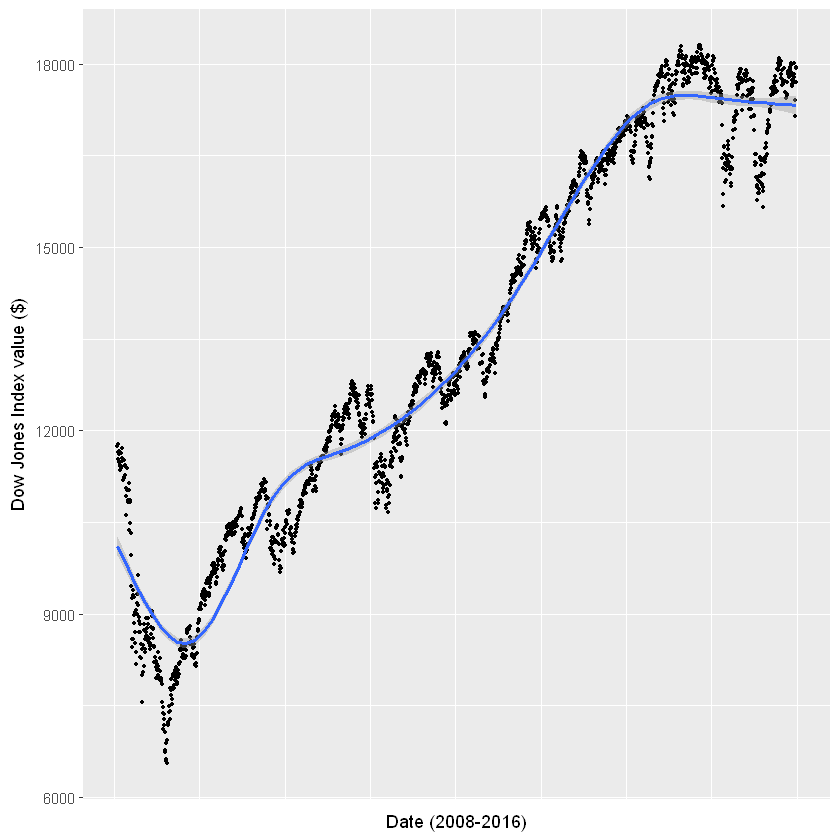

In [45]:
ggplot(data = tabela, mapping = aes(x = -X, y = CloseInt)) + 
  geom_point(size=0.75) + geom_smooth() + labs(x = "Date (2008-2016)", y = "Dow Jones Index value ($)") +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())

In [11]:
gor <- sum(tabela$Gibanje)
gor
round(gor/dim(tabela)[1], 2) 

[1] 1075

[1] 0.54

In [130]:
write.csv(tabela, file = "files/DowJones.csv")

Naslove najpopularnejših novic sem uvozil kar v obliki csv. Tako obliko podatkov sem našel na naslednjem naslovu: https://www.kaggle.com/aaron7sun/stocknews
Tabela vključuje dva stoplca, "Date" in "News". Pri vsakem datumu je nato vnešenih 25 naslovov dnevnih novic.
Obdelava podatkov je obsegala naslednje korake:
- iz naslovov sem odstranil znak "$" (izkazalo se je namreč, da kasneje lahko povzroča težave).
- združil sem novice za posamezni datum. Tako imam samo po en vnos za en datum, ne 25 različnih vnosov kot prej. To sem dosegel s pomočjo funkcije "aggregate".
- datume sem iz oblike "2016-07-01" pretvoril v obliko "Jul 1, 2016". Tako obliko imam namreč v prvi tabeli (gibanje borznega indeksa) in ker bom potem združil obe tabeli z "inner join-om" moram zagotoviti, da so datumi zapisani v enakem formatu.

In [35]:
D2 = read.csv("files/RedditNews.csv", header=T)
D2$News <- as.character(D2$News)
head(D2)
dim(D2)

Date,News
2016-07-01,"A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898."
2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,"The president of France says if Brexit won, so can Donald Trump"
2016-07-01,British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime.
2016-07-01,100+ Nobel laureates urge Greenpeace to stop opposing GMOs
2016-07-01,Brazil: Huge spike in number of police killings in Rio ahead of Olympics


[1] 73608     2

In [36]:
m <- D2$News
#v <- rep(0, 73608)
for (i in 1:73608) {
    #odstranim dolarje, ki kasneje povzročajo težave
    m[[i]] <- gsub('^(.*)(\\$)(.*)$', '\\1\\3', m[[i]])
}

D2$News <- m

In [37]:
news <- data.frame(aggregate(News ~ Date, D2, paste))
news$News <- as.character(news$News)

In [38]:
firstup <- function(x) {
   substr(x, 1, 1) <- toupper(substr(x, 1, 1))
x
}

datumi <- news$Date
v <- rep(0, 2943)
for (i in 1:2943) {
    v[[i]] <- format(as.Date(datumi[[i]]), format="%b %d, %Y")
    v[[i]] <- firstup(v[[i]])
    #da se znebim ničle pri dnenvih
    v[[i]] <- gsub('^(.+)(0)(\\d,.+)$', '\\1\\3', v[[i]])
}

In [39]:
for (i in 1:2943) {
    #da nastavim prava imena mesecev (Oct, May, Aug)
    v[[i]] <- gsub('^(Avg)(.+)$', 'Aug\\2', v[[i]])
    v[[i]] <- gsub('^(Maj)(.+)$', 'May\\2', v[[i]])
    v[[i]] <- gsub('^(Okt)(.+)$', 'Oct\\2', v[[i]])
}
head(v)

[1] "Jun 8, 2008"  "Jun 9, 2008"  "Jun 10, 2008" "Jun 11, 2008" "Jun 12, 2008"
[6] "Jun 13, 2008"

In [40]:
news$Date <- v
news <- news[rev(rownames(news)),]
head(news)

,Date,News
2943,"Jul 1, 2016","c(""A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898."", ""IMF chief backs Athens as permanent Olympic host"", ""The president of France says if Brexit won, so can Donald Trump"", ""British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime."", ""100+ Nobel laureates urge Greenpeace to stop opposing GMOs"", ""Brazil: Huge spike in number of police killings in Rio ahead of Olympics"", ""Austria's highest court annuls presidential election narrowly lost by right-wing candidate."", ""Facebook wins privacy case, can track any Belgian it wants: Doesn't matter if Internet users are logged into Facebook or not"", ""Switzerland denies Muslim girls citizenship after they refuse to swim with boys at school: The 12- and 14-year-old will no longer be considered for naturalised citizenship because they have not complied with the school curriculum, authorities in Basel said"", ""China kills millions of innocent meditators for their organs, report finds"", ""France Cracks Down on Factory Farms - A viral video campaign has moved the govt to act. In footage shared widely online, animals writhe in pain as they bleed to death or are dismembered, in violation of rules requiring they be rendered unconscious before slaughter."", ""Abbas PLO Faction Calls Killer of 13-Year-Old American-Israeli Girl a Martyr"", ""Taiwanese warship accidentally fires missile towards China"", ""Iran celebrates American Human Rights Week, mocks U.S. rights record"", ""U.N. panel moves to curb bias against L.G.B.T. people despite fierce resistance from Muslim and African countries."", ""The United States has placed Myanmar, Uzbekistan, Sudan and Haiti on its list of worst human trafficking offenders."", ""S&amp;P revises European Union credit rating to 'AA' from 'AA+'"", ""India gets 1 billion loan from World Bank for solar mission"", ""U.S. sailors detained by Iran spoke too much under interrogation: Navy"", ""Mass fish kill in Vietnam solved as Taiwan steelmaker accepts responsibility for pollution"", ""Philippines president Rodrigo Duterte urges people to kill drug addicts | Duterte, 71, won power in a landslide after a campaign dominated by threats to kill tens of thousands in a war on crime"", ""Spain arrests three Pakistanis accused of promoting militancy"", ""Venezuela, where anger over food shortages is still mounting, continued to be roiled this week by angry protests and break-ins of grocery stores and businesses that have left five dead, at least 30 injured and 200 arrested, according to various news reports."", ""A Hindu temple worker has been killed by three men on a motorcycle, local police have said. More than 40 people have been killed in attacks blamed on Islamist militants in Bangladesh since February 2013, including secular bloggers, academics, gay rights activists and members of religious minorities."", ""Ozone layer hole seems to be healing - US &amp; UK team shows it's shrunk &amp; may slowly recover. \""If you had to have an ozone hole anywhere in the world, it'd be Antarctica because its not teeming with life. It showed us if we didnt back off with these chemicals, wed have a crisis.\"""" )"
2942,"Jun 30, 2016","c(""Jamaica proposes marijuana dispensers for tourists at airports following legalisation: The kiosks and desks would give people a license to purchase up to 2 ounces of the drug to use during their stay"", ""Stephen Hawking says pollution and 'stupidity' still biggest threats to mankind: we have certainly not become less greedy or less stupid in our treatment of the environment over the past decade"", ""Boris Johnson says he will not run for Tory party leadership"", ""Six gay men in Ivory Coast were abused and forced to flee their homes after they were pictured 

Sedaj obe tabeli staknem z "inner join-om" po stolpcu "Date". To storim s funkcijo "merge". Na koncu malo "polepšam" še vnose v stolpcu "News". Odstranim vse "non alphanumeric" znake, razen presledkov in apostrofov.

In [44]:
test <- merge(tabela, news, by = "Date")

In [45]:
dim(test)
dim(tabela)

[1] 1990    6

[1] 1990    5

In [1]:
poskus <- test[with(test, order(X)), ]
poskus$Open <- NULL
poskus$Close <- NULL
poskus$X <- NULL

In [50]:
poskus$News <- gsub('b"|b\'|\\\\|\\"', "", poskus$News) 
poskus$News <- gsub("[^[:alnum:][:space:]']", "", poskus$News)
poskus$News <- gsub("^c(.+)$", "\\1", poskus$News)
poskus <- poskus[, c('Date', 'Gibanje', 'News')]

Rezultat je končna tabela s tremi stoplci: "Date", "Gibanje" in "News". Podatki so tako pripravljeni za nadaljnjo analizo (uporaba metod strojnega učenja in poskus napovedanja gibanja indeksa na podlagi naslovov). Tabelo še shranim v "Zdruzena.csv".

In [51]:
head(poskus)

,Date,Gibanje,News
829,"Jul 1, 2016",1,A 117yearold woman in Mexico City finally received her birth certificate and died a few hours later Trinidad Alvarez Lira had waited years for proof that she had been born in 1898 IMF chief backs Athens as permanent Olympic host The president of France says if Brexit won so can Donald Trump British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike The man is the subject of a sexual risk order despite having never been convicted of a crime 100 Nobel laureates urge Greenpeace to stop opposing GMOs Brazil Huge spike in number of police killings in Rio ahead of Olympics Austria's highest court annuls presidential election narrowly lost by rightwing candidate Facebook wins privacy case can track any Belgian it wants Doesn't matter if Internet users are logged into Facebook or not Switzerland denies Muslim girls citizenship after they refuse to swim with boys at school The 12 and 14yearold will no longer be considered for naturalised citizenship because they have not complied with the school curriculum authorities in Basel said China kills millions of innocent meditators for their organs report finds France Cracks Down on Factory Farms A viral video campaign has moved the govt to act In footage shared widely online animals writhe in pain as they bleed to death or are dismembered in violation of rules requiring they be rendered unconscious before slaughter Abbas PLO Faction Calls Killer of 13YearOld AmericanIsraeli Girl a Martyr Taiwanese warship accidentally fires missile towards China Iran celebrates American Human Rights Week mocks US rights record UN panel moves to curb bias against LGBT people despite fierce resistance from Muslim and African countries The United States has placed Myanmar Uzbekistan Sudan and Haiti on its list of worst human trafficking offenders SampP revises European Union credit rating to 'AA' from 'AA' India gets 1 billion loan from World Bank for solar mission US sailors detained by Iran spoke too much under interrogation Navy Mass fish kill in Vietnam solved as Taiwan steelmaker accepts responsibility for pollution Philippines president Rodrigo Duterte urges people to kill drug addicts Duterte 71 won power in a landslide after a campaign dominated by threats to kill tens of thousands in a war on crime Spain arrests three Pakistanis accused of promoting militancy Venezuela where anger over food shortages is still mounting continued to be roiled this week by angry protests and breakins of grocery stores and businesses that have left five dead at least 30 injured and 200 arrested according to various news reports A Hindu temple worker has been killed by three men on a motorcycle local police have said More than 40 people have been killed in attacks blamed on Islamist militants in Bangladesh since February 2013 including secular bloggers academics gay rights activists and members of religious minorities Ozone layer hole seems to be healing US amp UK team shows it's shrunk amp may slowly recover If you had to have an ozone hole anywhere in the world it'd be Antarctica because its not teeming with life It showed us if we didnt back off with these chemicals wed have a crisis
1112,"Jun 30, 2016",1,Jamaica proposes marijuana dispensers for tourists at airports following legalisation The kiosks and desks would give people a license to purchase up to 2 ounces of the drug to use during their stay Stephen Hawking says pollution and 'stupidity' still biggest threats to mankind we have certainly not become less greedy or less stupid in our treatment of the environment over the past decade Boris Johnson says he will not run for Tory party leadership Six gay men in Ivory Coast were abused and forced to flee their homes after they were pictured signing a condolence book for victims of the recent attack on a gay nightclub in Florida Switzerland denies citizenship to Muslim immigrant girls who refused to swim with boys report Palestinian terrorist stabs israeli tee

In [52]:
dim(poskus)

[1] 1990    3

In [53]:
write.csv(poskus, file = "files/Zdruzena.csv")